<a href="https://colab.research.google.com/github/surajn28/NMA-Transfer_Learning/blob/main/weight_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import ResNet

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import os.path as osp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader
class BasicBlock(nn.Module):
  """ResNet in PyTorch.
      Reference:
      [1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
        Deep Residual Learning for Image Recognition. arXiv:1512.03385
  """

  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=2):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    # out = F.avg_pool2d(out, 4)
    out = self.avgpool(out)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out


def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
  return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
  return ResNet(Bottleneck, [3, 4, 6, 3])

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.chdir('/content/gdrive/MyDrive/NMA/NMA-Transfer_Learning')
print(os.getcwd())
print(os.listdir())

/content/gdrive/MyDrive/NMA/NMA-Transfer_Learning
['.git', 'README.md', 'ResNet.py', 'Tansfer_Learning.ipynb', 'Transfer_learning_FER_ResNet.ipynb', 'data_collect.py', 'data_loader.py', 'load_vgg11_demo.ipynb', 'prepare_files', 'test.txt', 'train.py', '__pycache__', 'results', 'checkpoint']


## Imports

In [5]:
# imports
import os
import gc
import csv
import glob
import torch
import pandas as pd
import PIL
import h5py
import multiprocessing

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from google.colab import drive
from ResNet import ResNet,BasicBlock,Bottleneck

# Set GPU

In [ ]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

# Class H5FileDataset

In [41]:
# Data loader with data augmentation

class H5FileDataset(Dataset):
    # dataloader output: (pic_indices, color_channel, height, width)
    def __init__(self, h5_filename, transform=None, target_transform=None):
        self.h5_filename = h5_filename
        self.img_h5_file = self._load_h5_file(self.h5_filename)
        self.all_labels = self.img_h5_file['labels'][:]
        self.transform = transform  # it just assign the "state" of transform, not apply it


    def __len__(self):
        return len(self.all_labels)


    def __getitem__(self, idx):
        img = self.img_h5_file['img_data'][idx]
        label = self.img_h5_file['labels'][idx]

        label = torch.as_tensor(label, dtype=torch.float64)

        img = np.transpose(img, [2, 0, 1])
        img = img.astype(np.double)
        img = torch.as_tensor(img, dtype=torch.float64)
        if self.transform is not None:
            img = self.transform(img)  # we're going to write specific methods for transform
        return img, label


    def _load_h5_file(self, h5_filename):
        file = h5py.File(h5_filename, 'r')
        img_data = file['pic_mat']
        img_labels = file['labels']
        return dict(file=file, img_data=img_data, labels=img_labels)


# Data Loader

Batch size: torch.Size([50, 3, 128, 128])


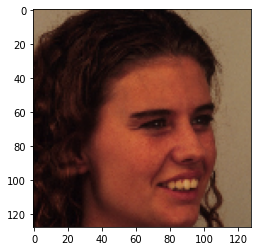

Text(0.5, 0.98, 'label 0.0')

<Figure size 432x288 with 0 Axes>

In [42]:
path = '../../datasets/KDEF_h5/new'

composed = transforms.Compose([transforms.RandomCrop([500, 500]), transforms.Resize([128, 128])])

trainset = H5FileDataset(os.path.join(path,'kdef_train_dataset.h5'), transform=composed)
testset = H5FileDataset(os.path.join(path,'kdef_val_dataset.h5'), transform=composed)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)


batch_images, batch_labels = next(iter(trainloader))
print('Batch size:', batch_images.shape)
plt.figure()
plt.imshow(batch_images[6].permute([1, 2, 0]).to(torch.uint8))
plt.show()
plt.suptitle(f'label {batch_labels[0]}')

# Training

In [43]:
def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

# hyper-parameters
use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
batch_size = 64
max_epochs = 15  # Please change this to 200
max_epochs_target = 10
# base_learning_rate = 0.5

base_learning_rate = 0.1

torchvision_transforms = True  # True/False if you want use torchvision augmentations

def train(net, epoch, trainloader, use_cuda=True):
  print('\nEpoch: %d' % epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    print('batch_idx ', batch_idx)
    targets = np.array(targets, dtype=int)
    # targets_num = np.zeros(len(targets))
    # print(targets_num.shape)
    # for idx_target in range(len(targets)):
    #   if targets[idx_target] == 'joy':
    #     targets_num[idx_target] = 0
    #   else:
    #     targets_num[idx_target] = 1
    targets = torch.as_tensor(targets, dtype=torch.long)
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()
    print('converted targets', batch_idx)

    optimizer.zero_grad()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    print('optimizer ', batch_idx)

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()
    print('correct ', batch_idx)

    # if batch_idx % 500 == 0:
    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
      
  return (train_loss/batch_idx, 100.*correct/total)


def test(net, epoch, testloader, outModelName, use_cuda=True):
  global best_acc
  net.eval()
  test_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
      print('batch_idx ', batch_idx)
      targets = np.array(targets, dtype=int)
      # targets_num = np.zeros(len(targets))
      # print(targets_num.shape)
      # for idx_target in range(len(targets)):
      #   if targets[idx_target] == 'joy':
      #     targets_num[idx_target] = 0
      #   else:
      #     targets_num[idx_target] = 1
      targets = torch.as_tensor(targets, dtype=torch.long)
      print('converted targets', batch_idx)
      if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

      outputs = net(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()

      if batch_idx % 200 == 0:
        print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
        checkpoint(net, acc, epoch, outModelName)
    return (test_loss/batch_idx, 100.*correct/total)

# checkpoint & adjust_learning_rate
def checkpoint(model, acc, epoch, outModelName):
  # Save checkpoint.
  print('Saving..')
  state = {
      'state_dict': model.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
  }
  if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
  torch.save(state, f'./checkpoint/{outModelName}.t7')

def adjust_learning_rate(optimizer, epoch):
  """decrease the learning rate at 100 and 150 epoch"""
  lr = base_learning_rate
  if epoch <= 9 and lr > 0.1:
    # warm-up training for large minibatch
    lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
  if epoch >= 100:
    lr /= 10
  if epoch >= 150:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

# if __name__=="__main__":


## Load the pretrained model weights

In [45]:
model = ResNet18()
model = model.double()
model = model.cuda()

checkpointPath = '../../datasets/Weights/pretrain.t7'

print(' ===> loading pretrained model from: ', checkpointPath)
if os.path.isfile(checkpointPath):
  state_dict = torch.load(checkpointPath)
  best_acc = state_dict['acc']
  print('Best Accuracy:', best_acc)
  if "state_dict" in state_dict:
      state_dict = state_dict["state_dict"]
  # remove prefixe "module."
  state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
  for k, v in model.state_dict().items():
    if k not in list(state_dict):
      print('key "{}" could not be found in provided state dict'.format(k))
    elif state_dict[k].shape != v.shape:
      print('key "{}" is of different shape in model and provided state dict'.format(k))
      state_dict[k] = v
  msg = model.load_state_dict(state_dict, strict=False)
  print("Load pretrained model with msg: {}".format(msg))
else:
  raise Exception('No pretrained weights found')

 ===> loading pretrained model from:  ../../datasets/Weights/pretrain.t7
Best Accuracy: tensor(98.5833)
Load pretrained model with msg: <All keys matched successfully>


# Freezing the model parameters

In [46]:
# Freeze the model parameters, you can also freeze some layers only

for param in model.parameters():
  param.requires_grad = False

In [47]:
num_ftrs = model.linear.in_features
model.linear = nn.Linear(num_ftrs, 2)
lr = 0.01
#model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.linear.parameters(),
    lr=lr,
    momentum=0.9,
    weight_decay=1e-4,
)

In [22]:
total_params = sum(p.numel() for p in model.parameters())
trainable_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Total Parameters:', total_params, 'Trainable parameters: ', trainable_total_params)

Total Parameters: 11169858 Trainable parameters:  1026


In [38]:
result_folder = '../../datasets/weights'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

logname = result_folder + model.__class__.__name__ + '_ResNetFERGtransferKDEF' + '.csv'

# Optimizer and criterion
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=base_learning_rate, momentum=0.9, weight_decay=1e-4)

outModelName = 'FERGtoKDEF'
if not os.path.exists(logname):
    with open(logname, 'w') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow(['epoch', 'train loss', 'train acc', 'test loss', 'test acc'])

for epoch in range(start_epoch, max_epochs):
    adjust_learning_rate(optimizer, epoch)
    
    train_loss, train_acc = train(model, epoch, trainloader, use_cuda=use_cuda)
    print('finished train epoch ', epoch)
    test_loss, test_acc = test(model, epoch, testloader, outModelName, use_cuda=use_cuda)
    print('finished test epoch ', epoch)
    with open(logname, 'a') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow([epoch, train_loss, train_acc.item(), test_loss, test_acc.item()])
    print(f'Epoch: {epoch} | train acc: {train_acc} | test acc: {test_acc}')


Epoch: 0
batch_idx  0
converted targets 0
optimizer  0
correct  0
0 10 Loss: 0.714 | Acc: 56.000% (28/50)
batch_idx  1
converted targets 1
optimizer  1


KeyboardInterrupt: ignored

In [34]:
# title plot results
results = pd.read_csv(f'/content/gdrive/MyDrive/datasets/weights/ResNetFERGtransferKDEF_{outModelName}.csv', sep =',')
results.head()

,epoch,train loss,train acc,test loss,test acc
0,0,0.443829,82.583336,0.204660,90.333336
1,1,0.088322,97.250000,0.029417,98.750000
2,2,0.011331,99.708336,0.003955,100.000000
3,3,0.034922,98.583336,0.001738,100.000000
4,4,0.003908,99.916664,0.000206,100.000000


In [36]:
train_accuracy = results['train acc'].values
test_accuracy = results['test acc'].values

print(f'Average Accuracy over {max_epochs_target} epochs:', sum(test_accuracy)//len(test_accuracy))
print(f'best accuraccy over {max_epochs_target} epochs:', max(test_accuracy))

Average Accuracy over 10 epochs: 91.0
best accuraccy over 10 epochs: 100.0


FileNotFoundError: ignored

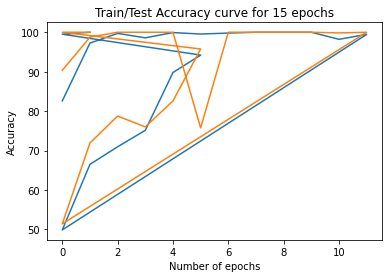

In [37]:
figureName = 'ResnettransferFERGtoKDEF' # change figure name

plt.plot(results['epoch'].values, train_accuracy, label='train')
plt.plot(results['epoch'].values, test_accuracy, label='test')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title(f'Train/Test Accuracy curve for {max_epochs} epochs')
plt.savefig(f'/content/results/{figureName}.png')
plt.legend()
plt.show()